In [17]:
# 📦 Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 📂 Load Dataset
df = pd.read_csv("Dataset.csv")
df.head()


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,11,'C1760492708','1','F','28007','M1823072687','28007','es_transportation',52.35,0
1,172,'C1222389110','3','M','28007','M1823072687','28007','es_transportation',14.75,0
2,106,'C879949041','3','F','28007','M1823072687','28007','es_transportation',3.73,0
3,86,'C409740988','5','M','28007','M1823072687','28007','es_transportation',61.42,0
4,152,'C671449181','3','F','28007','M692898500','28007','es_health',9.05,0


In [18]:
# 🧹 Clean Data

# Drop unnecessary columns
df_cleaned = df.drop(columns=['customer', 'merchant', 'zipcodeOri', 'zipMerchant'])

# Clean and encode categorical columns
for col in ['age', 'gender', 'category']:
    df_cleaned[col] = df_cleaned[col].astype(str).str.replace("'", "").str.strip()

# Label Encoding
le = LabelEncoder()
for col in ['age', 'gender', 'category']:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])


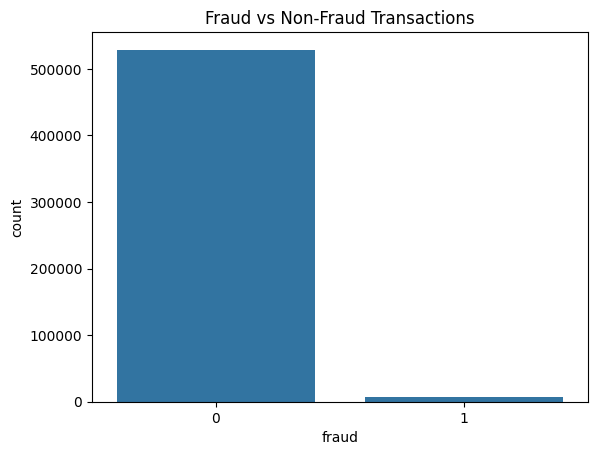

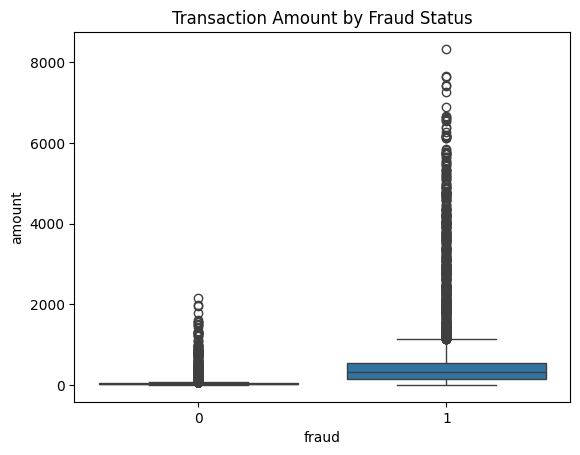

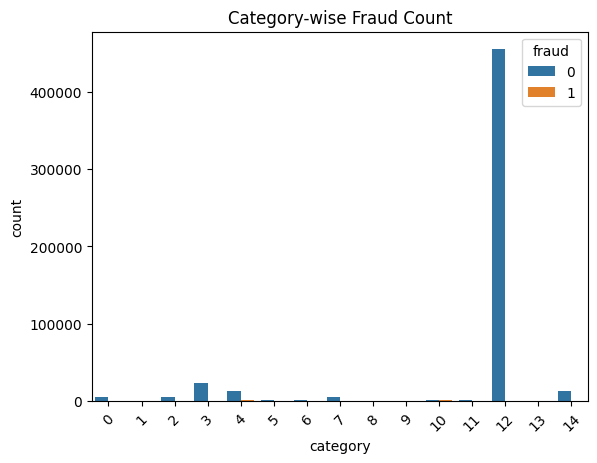

In [19]:
# 📊 Visualizations

# Countplot: Fraud vs Non-Fraud
sns.countplot(data=df_cleaned, x='fraud')
plt.title("Fraud vs Non-Fraud Transactions")
plt.show()

# Boxplot: Amount by Fraud
sns.boxplot(x='fraud', y='amount', data=df_cleaned)
plt.title("Transaction Amount by Fraud Status")
plt.show()

# Category vs Fraud
sns.countplot(x='category', hue='fraud', data=df_cleaned)
plt.title("Category-wise Fraud Count")
plt.xticks(rotation=45)
plt.show()


 0: 'es_transportation',
    1: 'es_health',
    2: 'es_education',
    3: 'es_others',
    4: 'es_food',
    5: 'es_fuel',
    6: 'es_hotelservices',
    7: 'es_hyper',
    8: 'es_parking',
    9: 'es_sportsandtoys',
    10: 'es_tech',
    11: 'es_wellness',
    12: 'es_leisure'


In [20]:
# 🤖 Build and Train Model

X = df_cleaned.drop("fraud", axis=1)
y = df_cleaned["fraud"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [22]:
# ✅ Evaluate Model

print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))

print("🎯 AUC-ROC Score:", roc_auc_score(y_test, y_proba))


📊 Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105723
           1       0.87      0.65      0.74      1313

    accuracy                           0.99    107036
   macro avg       0.93      0.82      0.87    107036
weighted avg       0.99      0.99      0.99    107036

🎯 AUC-ROC Score: 0.9681613023165575


In [24]:
import joblib

# Save the trained model
joblib.dump(model, "fraud_model.pkl")

# Save the LabelEncoder used for age, gender, category
joblib.dump(le, "label_encoder.pkl")

print("✅ Model and encoder saved!")


✅ Model and encoder saved!


In [25]:
import pandas as pd
import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
import os

# --- Debugging: Check current working directory and file existence ---
print(f"Current working directory: {os.getcwd()}")
model_file_path = "fraud_model.pkl" # Make sure this path is correct
dataset_file_path = "Dataset.csv"
test_dataset_file_path = "test_Dataset1.csv"

print(f"Checking for {model_file_path}: {os.path.exists(model_file_path)}")
print(f"Checking for {dataset_file_path}: {os.path.exists(dataset_file_path)}")
print(f"Checking for {test_dataset_file_path}: {os.path.exists(test_dataset_file_path)}")
# --- End Debugging ---

try:
    # Load model
    model = joblib.load(model_file_path)
except FileNotFoundError:
    print(f"Error: '{model_file_path}' not found. Please ensure the file is in the same directory as the script or provide the full path.")
    exit() # Exit if the model cannot be loaded

# Load new data (test data)
new_data = pd.read_csv(test_dataset_file_path)
train_data = pd.read_csv(dataset_file_path)

# Combine for consistent encoding across train and test
combined_data = pd.concat([train_data, new_data], ignore_index=True)

# Drop irrelevant columns for cleaning and encoding
# Ensure 'fraud' is also dropped from new_data_cleaned if it's the target variable
# and should not be used as a feature for prediction.
# Make a copy to avoid SettingWithCopyWarning
new_data_cleaned = new_data.drop(columns=['customer', 'merchant', 'zipcodeOri', 'zipMerchant', 'fraud'], errors='ignore').copy()
combined_data_cleaned = combined_data.drop(columns=['customer', 'merchant', 'zipcodeOri', 'zipMerchant', 'fraud'], errors='ignore').copy()


# Initialize LabelEncoders for each categorical column
le_age = LabelEncoder()
le_gender = LabelEncoder()
le_category = LabelEncoder()

# Clean and fit LabelEncoder on combined data for robust transformation
for col, encoder in zip(['age', 'gender', 'category'], [le_age, le_gender, le_category]):
    # Clean data: convert to string, remove single quotes, strip whitespace
    combined_data_cleaned[col] = combined_data_cleaned[col].astype(str).str.replace("'", "").str.strip()
    new_data_cleaned[col] = new_data_cleaned[col].astype(str).str.replace("'", "").str.strip()

    # Fit encoder on the *cleaned* combined unique values
    encoder.fit(combined_data_cleaned[col])

    # Transform the new data using the fitted encoder
    new_data_cleaned[col] = encoder.transform(new_data_cleaned[col])

# Predict
predictions = model.predict(new_data_cleaned)
probabilities = model.predict_proba(new_data_cleaned)[:, 1]

# Add predictions to the original dataframe
new_data['Predicted_Fraud'] = predictions
new_data['Fraud_Probability'] = probabilities

# Evaluate performance on test data
true_labels = new_data['fraud'] # Assuming 'fraud' is the true label column in test_Dataset1.csv

print("\n📊 Classification Report:")
print(classification_report(true_labels, predictions))

print("\n🎯 AUC-ROC Score:", roc_auc_score(true_labels, probabilities))

# Save or display the first few rows of data with predictions
print("\nFirst 5 rows of data with predictions:")
print(new_data[['amount', 'category', 'Predicted_Fraud', 'Fraud_Probability']].head())

# Optionally save to CSV
new_data.to_csv("Predicted_NewData.csv", index=False)
print("✅ Predictions saved to Predicted_NewData.csv")

Current working directory: C:\Users\dsaiv\OneDrive\Desktop\Desktop_Folders\Final Fraud Detection
Checking for fraud_model.pkl: True
Checking for Dataset.csv: True
Checking for test_Dataset1.csv: True

📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58757
           1       0.87      0.66      0.75       708

    accuracy                           0.99     59465
   macro avg       0.93      0.83      0.87     59465
weighted avg       0.99      0.99      0.99     59465


🎯 AUC-ROC Score: 0.9672615519112567

First 5 rows of data with predictions:
   amount            category  Predicted_Fraud  Fraud_Probability
0   11.65  es_transportation'                0                0.0
1    1.60  es_transportation'                0                0.0
2   33.36  es_transportation'                0                0.0
3    8.01  es_transportation'                0                0.0
4   38.11  es_transportation'           

In [26]:
print(train_data['fraud'].value_counts())


fraud
0    528686
1      6492
Name: count, dtype: int64
